# Tutorial file for the r-place-emergence package

#### Imports

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
import json

import rplacem.canvas_part as cp
import rplacem.canvas_part_statistics as cpst
import rplacem.compute_variables as compute
import rplacem.variables_rplace2022 as var
import rplacem.utilities as util
import rplacem.plot_utilities as plot

### Choose an index from the atlas.json file to identify a composition of interest

The r/place [atlas](https://place-atlas.stefanocoding.me/about)
"is an atlas aiming to chart all the artworks created during the r/place April Fools event on Reddit in 2022. It is made with information to each artwork of the canvas provided by the community. The original code was developed by Roland Rytz and is available under the free AGPL license on GitHub. The currently maintained version of the website is managed by Stefano Haagmans and is obtainable under the same license within a [GitHub fork](https://github.com/placeAtlas/atlas). Initial images are provided by Alex Tsernoh."

Each "artwork" or as we call it here, "composition", is indexed according to a string of numbers, found in the atlas.json file. Here, we choose one arbitrarily for demonstration

In [71]:
atlas_id_index = '000006'#'000297'#'000006'#

### Load all the pixel data from the npz file

Next, we load all the pixel change data from the npz file. This npz file is a condensed, time-sorted version of the 79 data files provided by reddit from the 2022 r/place experiment. The get_all_pixel_changes() function loads this data and places it into an array with 6 columns

In [72]:
pixel_changes_all = util.get_all_pixel_changes()

Print the columns of the pixel_changes_all array for reference

In [73]:
print('  seconds: ' + str(pixel_changes_all['seconds']))
print('  x coord: ' + str(pixel_changes_all['xcoor']))
print('  y coord: ' + str(pixel_changes_all['ycoor']))
print('  user id: ' + str(pixel_changes_all['user']))
print(' color id: ' + str(pixel_changes_all['color']))
print('mod event: ' + str(pixel_changes_all['moderator']))

  seconds: [3.15000000e-01 1.26710000e+01 1.66260000e+01 ... 3.00590172e+05
 3.00590195e+05 3.00590207e+05]
  x coord: [  42  999   44 ...  770 1046    0]
  y coord: [  42  999   42 ...  866 1721 1999]
  user id: [4068945 4068946 4068947 ... 2778754 1591567  583562]
 color id: [16  7 10 ... 31 31 31]
mod event: [False False False ... False False False]


### Define two types of CanvasPart objects

The CanvasPart class is a superclass with subclasses CanvasComposition and CanvasArea. You can think of a CanvasPart as a part of the canvas defined by a spatial border, which can be either defined by the edge of a particular artwork composition as defined by the r/place Atlas or it can be defined by an arbitrary user-defined border path, which can take any shape. The maximum size of a user-defined border is the size of the canvas itself. 

##### Define a CanvasCompsition object

To define a CanvasComposition object, you must supply the atlas composition id index and the pixel change data loaded from the npz file. The constructor then finds and sets the border path, the x and y coordinates inside the border, and the pixel changes within the border of the composition. 

In [74]:
atlas, atlas_size = util.load_atlas()

In [75]:
canvas_comp = cp.CanvasPart(id = atlas_id_index, atlas = atlas, verbose = True)

set border path (with _get_atlas_border() if composition)
set coordinates (with _get_bounded_coords() if is not rectangle)
_reject_off_times()
set pixel changes with _find_pixel_changes_in_boundary()
    find pixels inside boundary
    sort pixel_changes vs coordinates
    determine if the pixel change is in the active timerange
    make pixel_changes output
    find redundant pixel changes
    find changes with cheated cooldown
_set_has_loc_jump()


In [76]:
util.check_time('cp.CanvasPart(id=atlas_id_index, pixel_changes_all=pixel_changes_all, atlas=atlas)')
# getting rid of ind for loop: 0.892 vs 1.632

         397 function calls (383 primitive calls) in 0.996 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.996    0.996 {built-in method builtins.exec}
        1    0.000    0.000    0.996    0.996 <string>:1(<module>)
        1    0.000    0.000    0.996    0.996 canvas_part.py:99(__init__)
        1    0.565    0.565    0.995    0.995 canvas_part.py:347(_find_pixel_changes_in_boundary)
        5    0.343    0.069    0.343    0.069 {method 'argsort' of 'numpy.ndarray' objects}
        1    0.014    0.014    0.249    0.249 canvas_part.py:433(_find_cheated_pix_change)
    41/27    0.063    0.002    0.180    0.007 {built-in method numpy.core._multiarray_umath.implement_array_function}
        7    0.000    0.000    0.117    0.017 fromnumeric.py:51(_wrapfunc)
        1    0.001    0.001    0.110    0.110 canvas_part.py:457(_find_redundant_pix_change)
        2    0.000    0.000    0.109    0.

In [77]:
print(canvas_comp.__str__())

CanvasPart 
Atlas Composition, id: 000006,         
Rectangle, 1 time-dependent border_path(s)
2989 pixels in total, x in [912, 960], y in [421, 481]        
117120 pixel changes (including 117120 in composition time ranges)        

Description: 
2builders2tools (2b2t) is the second-oldest running multiplayer server for the game Minecraft. It uses an anarchy format, meaning there are minimal rules in place for players.

The 2b2t logo was one of the first factions to form, with pixels being placed within the first few seconds. Though many groups and streamers tried to attack or replace it through many means, 2b2t prevailed. 

Pixel changes: 
[(  1226.869,    0,  1159668, 16,  True, False, False, False, False)
 (  1231.68 ,   61,  3054718, 16,  True, False, False, False, False)
 (  1251.755,  122,  2720365, 16,  True, False, False, False, False) ...
 (300511.144, 2319, 10380382, 31,  True, False, False,  True, False)
 (300553.777, 2263,   521579, 31,  True, False, False,  True, False)
 

##### Define a CanvasArea object
To define a CanvasArea object, you must supply the border path and the pixel changes from the npz file. 
The border path is a numpy array of x,y points that form the path of the border of the canvas

In [78]:
border_path = [[[0,0],[0,10],[10,10],[10,0]]]
canvas_area = cp.CanvasPart(border_path=border_path, pixel_changes_all=pixel_changes_all)
canvas_area.description = 'The top left 100 pixels'

In [79]:
print(canvas_area)

CanvasPart 
user-defined area, name: rectangle_0.0_to_10.10,         
Rectangle, 1 time-dependent border_path(s)
121 pixels in total, x in [0, 10], y in [0, 10]        
197538 pixel changes (including 197538 in composition time ranges)        

Description: 
The top left 100 pixels 

Pixel changes: 
[(2.17030000e+01, 24, 4068948, 22,  True, False, False, False, False)
 (1.69534000e+02,  0, 4068955, 27,  True, False, False, False, False)
 (4.90058000e+02, 12, 4068959, 25,  True, False, False, False, False) ...
 (3.00589027e+05,  0, 1256236, 31,  True, False, False,  True, False)
 (3.00589360e+05,  1,  364556, 31,  True, False, False,  True, False)
 (3.00589387e+05,  0, 1295679, 31,  True, False, False,  True, False)]        



## Define a CanvasPartStatistics object

In [86]:
util.check_time('''canvas_part_stat = cpst.CanvasPartStatistics(canvas_comp,
                                             n_tbins=1000,
                                             tmax=var.TIME_TOTAL,
                                             compute_vars={'stability': 1, 'entropy': 1, 
                                                           'transitions': 1, 'attackdefense': 1},
                                             sliding_window=14400,
                                             returnt_binwidth=100,
                                             trans_param=[0.3, 0.1, 7200, 14400],
                                             timeunit=300,
                                             dont_keep_dir=False, 
                                             compression='LZ77',
                                             flattening='hilbert_pkg')''')

         36403541 function calls (36382468 primitive calls) in 32.637 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001   32.637   32.637 {built-in method builtins.exec}
        1    0.000    0.000   32.637   32.637 <string>:1(<module>)
        1    0.027    0.027   32.637   32.637 canvas_part_statistics.py:234(__init__)
        1    0.610    0.610   32.314   32.314 compute_variables.py:204(main_variables)
     1000    1.495    0.001   28.045    0.028 entropy.py:22(calc_compressed_size)
  2989000   16.130    0.000   25.925    0.000 hilbertcurve.py:201(distance_from_point)
  2989000    2.848    0.000    9.199    0.000 hilbertcurve.py:100(_transpose_to_hilbert_integer)
  2989000    1.090    0.000    3.677    0.000 hilbertcurve.py:110(<listcomp>)
53290/32221    0.071    0.000    2.871    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
  5978000    1.237    0.000    2.58

In [84]:
util.check_time('''canvas_part_stat = cpst.CanvasPartStatistics(canvas_comp,
                                             n_tbins=1000,
                                             tmax=var.TIME_TOTAL,
                                             compute_vars={'stability': 1, 'entropy': 1, 
                                                           'transitions': 1, 'attackdefense': 1},
                                             sliding_window=14400,
                                             returnt_binwidth=100,
                                             trans_param=[0.3, 0.1, 7200, 14400],
                                             timeunit=300,
                                             dont_keep_dir=False, 
                                             compression='DEFLATE',
                                             flattening='ravel')''')

         531554 function calls (510480 primitive calls) in 4.526 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.526    4.526 {built-in method builtins.exec}
        1    0.000    0.000    4.525    4.525 <string>:1(<module>)
        1    0.027    0.027    4.525    4.525 canvas_part_statistics.py:234(__init__)
        1    0.589    0.589    4.205    4.205 compute_variables.py:204(main_variables)
53292/32222    0.067    0.000    2.791    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     6053    0.009    0.000    1.188    0.000 fromnumeric.py:69(_wrapreduction)
    12046    1.186    0.000    1.186    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     1990    0.002    0.000    1.178    0.001 <__array_function__ internals>:177(sum)
     1990    0.004    0.000    1.174    0.001 fromnumeric.py:2160(sum)
     2000    0.004    0.000    0.648    0.000 compute_vari

In [87]:
canvas_part_stat = cpst.CanvasPartStatistics(canvas_comp,
                                             n_tbins=40,
                                             tmax=var.TIME_TOTAL,
                                             compute_vars={'stability': 3, 'entropy': 3, 
                                                           'transitions': 3, 'attackdefense': 3},
                                             sliding_window=14400,
                                             returnt_binwidth=100,
                                             trans_param=[0.2, 0.05, 7200, 10800],
                                             timeunit=300,
                                             dont_keep_dir=False)

Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/VsTimeStab/MostStableColor_time000000t_fps15.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/VsTimeStab/MostStableColor_time000000t_fps15.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/VsTimeStab/MostStableColor_time000000t_fps15.mp4
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/VsTime/canvaspart_fps15.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/VsTime/canvaspart_fps15.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/VsTime/canvaspart_fps15.mp4
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/AttDefImg/SlidingRef_time000_fps6.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/AttDefImg/SlidingRef_time000_fps6.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000006/AttDefImg/SlidingRef_time000_fps6.mp4


### Get the pixel changes over time, plot, and save a movie of the frames

Now, we can start to examine how the two CanvasPart objects change over time. 

First, let's plot the canvas_comp object for the specified time steps. You'll notice the plotting function returns a list of indices that allow us to quickly select the pixel change data at different time points inside the boundary. The time_inds_list_comp will come in handy for time-step calculations later on. 

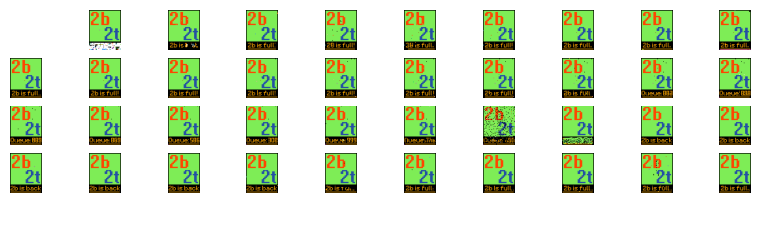

In [88]:
plot.show_canvas_part_over_time(canvas_part_stat.true_image, figsize = (10,3))

We can do the same for the canvas_area object

In [36]:
canvas_area_stat = cpst.CanvasPartStatistics(canvas_area,
                                             n_tbins=40,
                                             tmax=var.TIME_TOTAL,
                                             compute_vars={'stability': 3, 'entropy': 3, 
                                                           'transitions': 3, 'attackdefense': 3},
                                             sliding_window=14400,
                                             returnt_binwidth=100,
                                             trans_param=[0.2, 0.05, 7200, 10800],
                                             timeunit=300,
                                             dont_keep_dir=False)

Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/VsTimeStab/MostStableColor_time000000t_fps15.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/VsTimeStab/MostStableColor_time000000t_fps15.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/VsTimeStab/MostStableColor_time000000t_fps15.mp4
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps15.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps15.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps15.mp4


Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/AttDefImg/SlidingRef_time000_fps6.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/AttDefImg/SlidingRef_time000_fps6.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/AttDefImg/SlidingRef_time000_fps6.mp4


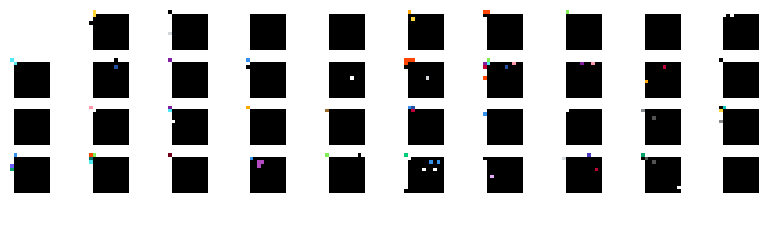

In [37]:
plot.show_canvas_part_over_time(canvas_area_stat.true_image, figsize = (10,3))

##### Save the frames as  movie

In [38]:
image_path = os.path.join(os.getcwd(), 'figs', '000297','VsTime')
image_path_area = os.path.join(os.getcwd(), 'figs', 'rectangle_0.0_to_10.10','VsTime')

In [39]:
util.save_movie(image_path, 
              movie_tool='moviepy',
              fps=6,
              codec='mpeg4',#'libx264',
              video_type='mov')# 'mp4'

util.save_movie(image_path_area, 
              movie_tool='moviepy',
              fps=6,
              codec='mpeg4',#'libx264',
              video_type='mov')# 'mp4'


Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/figs/000297/VsTime/canvaspart_fps6.mov.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/figs/000297/VsTime/canvaspart_fps6.mov



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/figs/000297/VsTime/canvaspart_fps6.mov
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps6.mov.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps6.mov



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps6.mov


# Plot

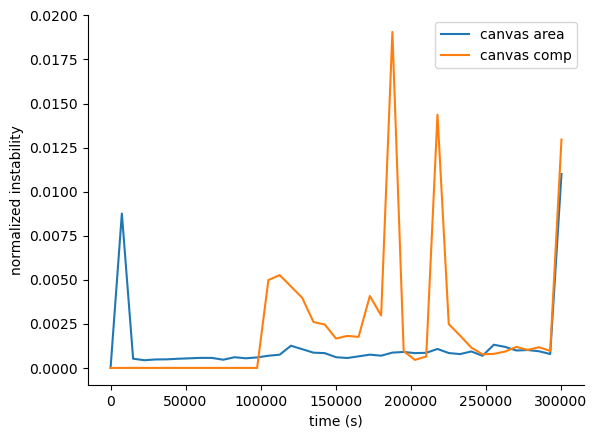

In [17]:
plt.plot(canvas_area_stat.t_ranges, canvas_area_stat.instability_norm.val, label = 'canvas area')
plt.plot(canvas_part_stat.t_ranges, canvas_part_stat.instability_norm.val, label='canvas comp')
sns.despine()
plt.ylabel('normalized instability')
plt.xlabel('time (s)')
sns.despine()
plt.ylabel('normalized instability')
plt.xlabel('time (s)')
plt.legend()

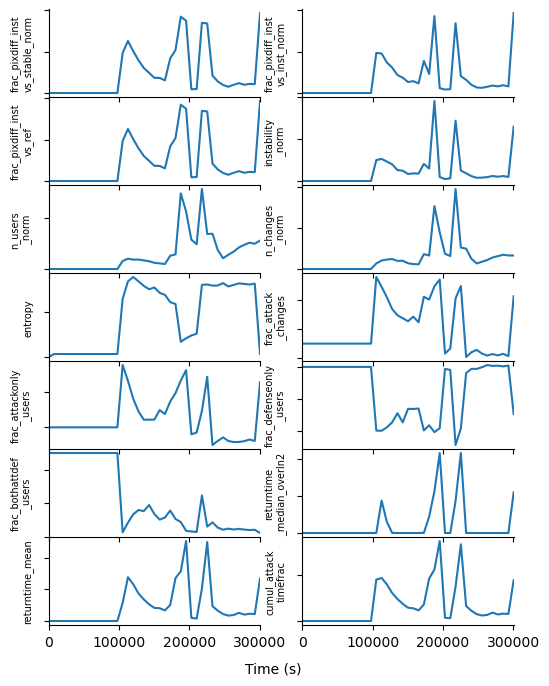

In [18]:
canvas_part_stat.fill_timeseries_info()
plot.cpstat_tseries(canvas_part_stat, figsize=(6,8), ncols=2, fontsize=7)

Save

In [ ]:
# Open a file and save the object using pickle.dump()
with open('canvas_comp_stat.pickle', 'wb') as f:
    pickle.dump(canvas_part_stat, f)